### Mounting Google Drive in Google Colab

This code mounts Google Drive to the Colab environment, allowing you to access files stored in Drive directly from Colab. After mounting, you can load datasets or save results to Google Drive.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Circle Detection Dataset Generation

This script creates a synthetic dataset for training and testing a YOLO model to detect circles in images. It generates images with circles of different sizes, colors, and backgrounds, and provides the necessary annotations in YOLO format. The dataset is then organized into training, validation, and test sets.

### How It Works

#### Generating Images

The script creates images with random backgrounds and places between 2 to 5 circles on each image. Circles are randomly sized and colored, and can be either filled or outlined. To avoid overlapping circles, it checks if a new circle’s center is sufficiently far from existing circles before drawing it.

#### Annotations

For each circle, the script calculates its position and size relative to the image dimensions. These details are saved in YOLO’s annotation format, which includes the class label (0 for circles) and normalized coordinates.

#### Saving Data

Images and their annotations are saved in specified directories. The dataset is divided into training, validation, and test sets. Each set is saved in its own directory for easy access.

### Directory Structure

- `images`: Contains all generated images.
- `labels`: Contains annotation files in YOLO format.
- `train`: Includes images and labels for training.
- `valid`: Includes images and labels for validation.
- `test`: Includes images and labels for testing.

### YOLO Annotation Format

Annotations are saved in YOLO format, which specifies:

- The class ID (0 for circles).
- The normalized coordinates of the circle's center (`x_center`, `y_center`).
- The normalized width and height of the circle.

This approach ensures that the dataset is diverse and suitable for training a robust circle detection model.


In [4]:
import cv2
import numpy as np
import os
from random import randint, choice, shuffle
from google.colab import drive


# Parameters
num_images = 1500  # Number of images to generate
image_size = (640, 640)  # Width, Height
background_colors = [(255, 255, 255), (0, 0, 0), (128, 128, 128), (255, 0, 0), (0, 255, 0), (0, 0, 255)]
circle_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
line_thicknesses = [1, 2, 3, 4, 5,6]
min_distance = 50  # Minimum distance between circle centers
num_classes = 1  # Number of classes (1 for circles)

# Paths
base_path = '/content/drive/MyDrive/circle_dataset'
images_path = os.path.join(base_path, 'images')
labels_path = os.path.join(base_path, 'labels')

def create_image_with_circles():
    img = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)  # Black background
    bg_color = choice(background_colors)
    img[:] = bg_color

    num_circles = randint(2, 5)  # Number of circles per image
    circles = []
    annotations = []

    for _ in range(num_circles):
        circle_type = choice(['filled', 'empty'])
        center = (randint(50, image_size[0] - 50), randint(50, image_size[1] - 50))
        radius = randint(10, 100)
        circle_color = choice(circle_colors)
        line_thickness = choice(line_thicknesses)

        # Ensuring circles do not overlap
        overlap = False
        for (cx, cy, r) in circles:
            distance = np.sqrt((center[0] - cx) ** 2 + (center[1] - cy) ** 2)
            if distance < (radius + r) + min_distance:
                overlap = True
                break

        if overlap:
            continue

        # Drawing the circle
        if circle_type == 'filled':
            cv2.circle(img, center, radius, circle_color, -1)
        else:  # empty
            cv2.circle(img, center, radius, circle_color, line_thickness)

        # YOLO annotation format (normalized)
        x_center = center[0] / image_size[0]
        y_center = center[1] / image_size[1]
        width = radius * 2 / image_size[0]
        height = radius * 2 / image_size[1]

        annotations.append(f"0 {x_center} {y_center} {width} {height}")

        circles.append((center[0], center[1], radius))

    return img, annotations

def save_images_and_labels():
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    # Generating images and labels
    image_label_pairs = []
    for i in range(num_images):
        img, annotations = create_image_with_circles()
        img_filename = f'image_{i}.png'
        label_filename = f'image_{i}.txt'
        cv2.imwrite(os.path.join(images_path, img_filename), img)
        with open(os.path.join(labels_path, label_filename), 'w') as f:
            f.write('\n'.join(annotations))
        image_label_pairs.append((img_filename, label_filename))

    # Shuffle and split dataset
    shuffle(image_label_pairs)
    num_train = int(0.8 * num_images)
    num_val = int(0.1 * num_images)
    num_test = num_images - num_train - num_val

    train_pairs = image_label_pairs[:num_train]
    val_pairs = image_label_pairs[num_train:num_train+num_val]
    test_pairs = image_label_pairs[num_train+num_val:]

    # split directories
    split_dirs = {
        'train': {'images': 'train/images', 'labels': 'train/labels'},
        'valid': {'images': 'valid/images', 'labels': 'valid/labels'},
        'test': {'images': 'test/images', 'labels': 'test/labels'}
    }

    # directories for splits
    for split in split_dirs.values():
        os.makedirs(os.path.join(base_path, split['images']), exist_ok=True)
        os.makedirs(os.path.join(base_path, split['labels']), exist_ok=True)

    # Save train, val, and test splits
    def save_split(split_name, pairs):
        for img_filename, label_filename in pairs:
            img_src = os.path.join(images_path, img_filename)
            label_src = os.path.join(labels_path, label_filename)
            img_dest = os.path.join(base_path, split_dirs[split_name]['images'], img_filename)
            label_dest = os.path.join(base_path, split_dirs[split_name]['labels'], label_filename)
            os.rename(img_src, img_dest)
            os.rename(label_src, label_dest)

    save_split('train', train_pairs)
    save_split('valid', val_pairs)
    save_split('test', test_pairs)

save_images_and_labels()


In [5]:
import yaml

# Paths
base_path = '/content/drive/MyDrive/circle_dataset'

# YAML content
yaml_content = {
    'train': os.path.join(base_path, 'train/images'),
    'val': os.path.join(base_path, 'valid/images'),
    'test': os.path.join(base_path, 'test/images'),
    'nc': 1,  # Number of classes
    'names': ['circle']  # Class names
}

# Save YAML file
yaml_file_path = os.path.join(base_path, 'dataset.yaml')
with open(yaml_file_path, 'w') as file:
    yaml.dump(yaml_content, file, default_flow_style=False)

print(f'YAML file saved at: {yaml_file_path}')


YAML file saved at: /content/drive/MyDrive/circle_dataset/dataset.yaml


In [6]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [7]:
from ultralytics import YOLO

### YOLOv8 Training for Circle Detection

This section outlines the training process for a YOLOv8 model using synthetic images of circles.

## Details
- Model: YOLOv8n (Nano version for faster experimentation)
- Epochs: 50 epochs were chosen. Initial training was done for 30 epochs, and the model was still converging. Increasing to 50 epochs aims to achieve better local minima.
- Batch Size: Set to 32. This batch size was selected to accelerate convergence and introduce some noise into the training process, which helps in improving generalization.
- Augmentation: Applied to enhance model robustness and generalization.

In [9]:
!yolo task= detect mode = train model=yolov8n.pt data=/content/drive/MyDrive/circle_dataset/dataset.yaml epochs=50 imgsz=640 batch=32 augment

Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/circle_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

In [10]:
!cp -r runs/ /content/drive/MyDrive/

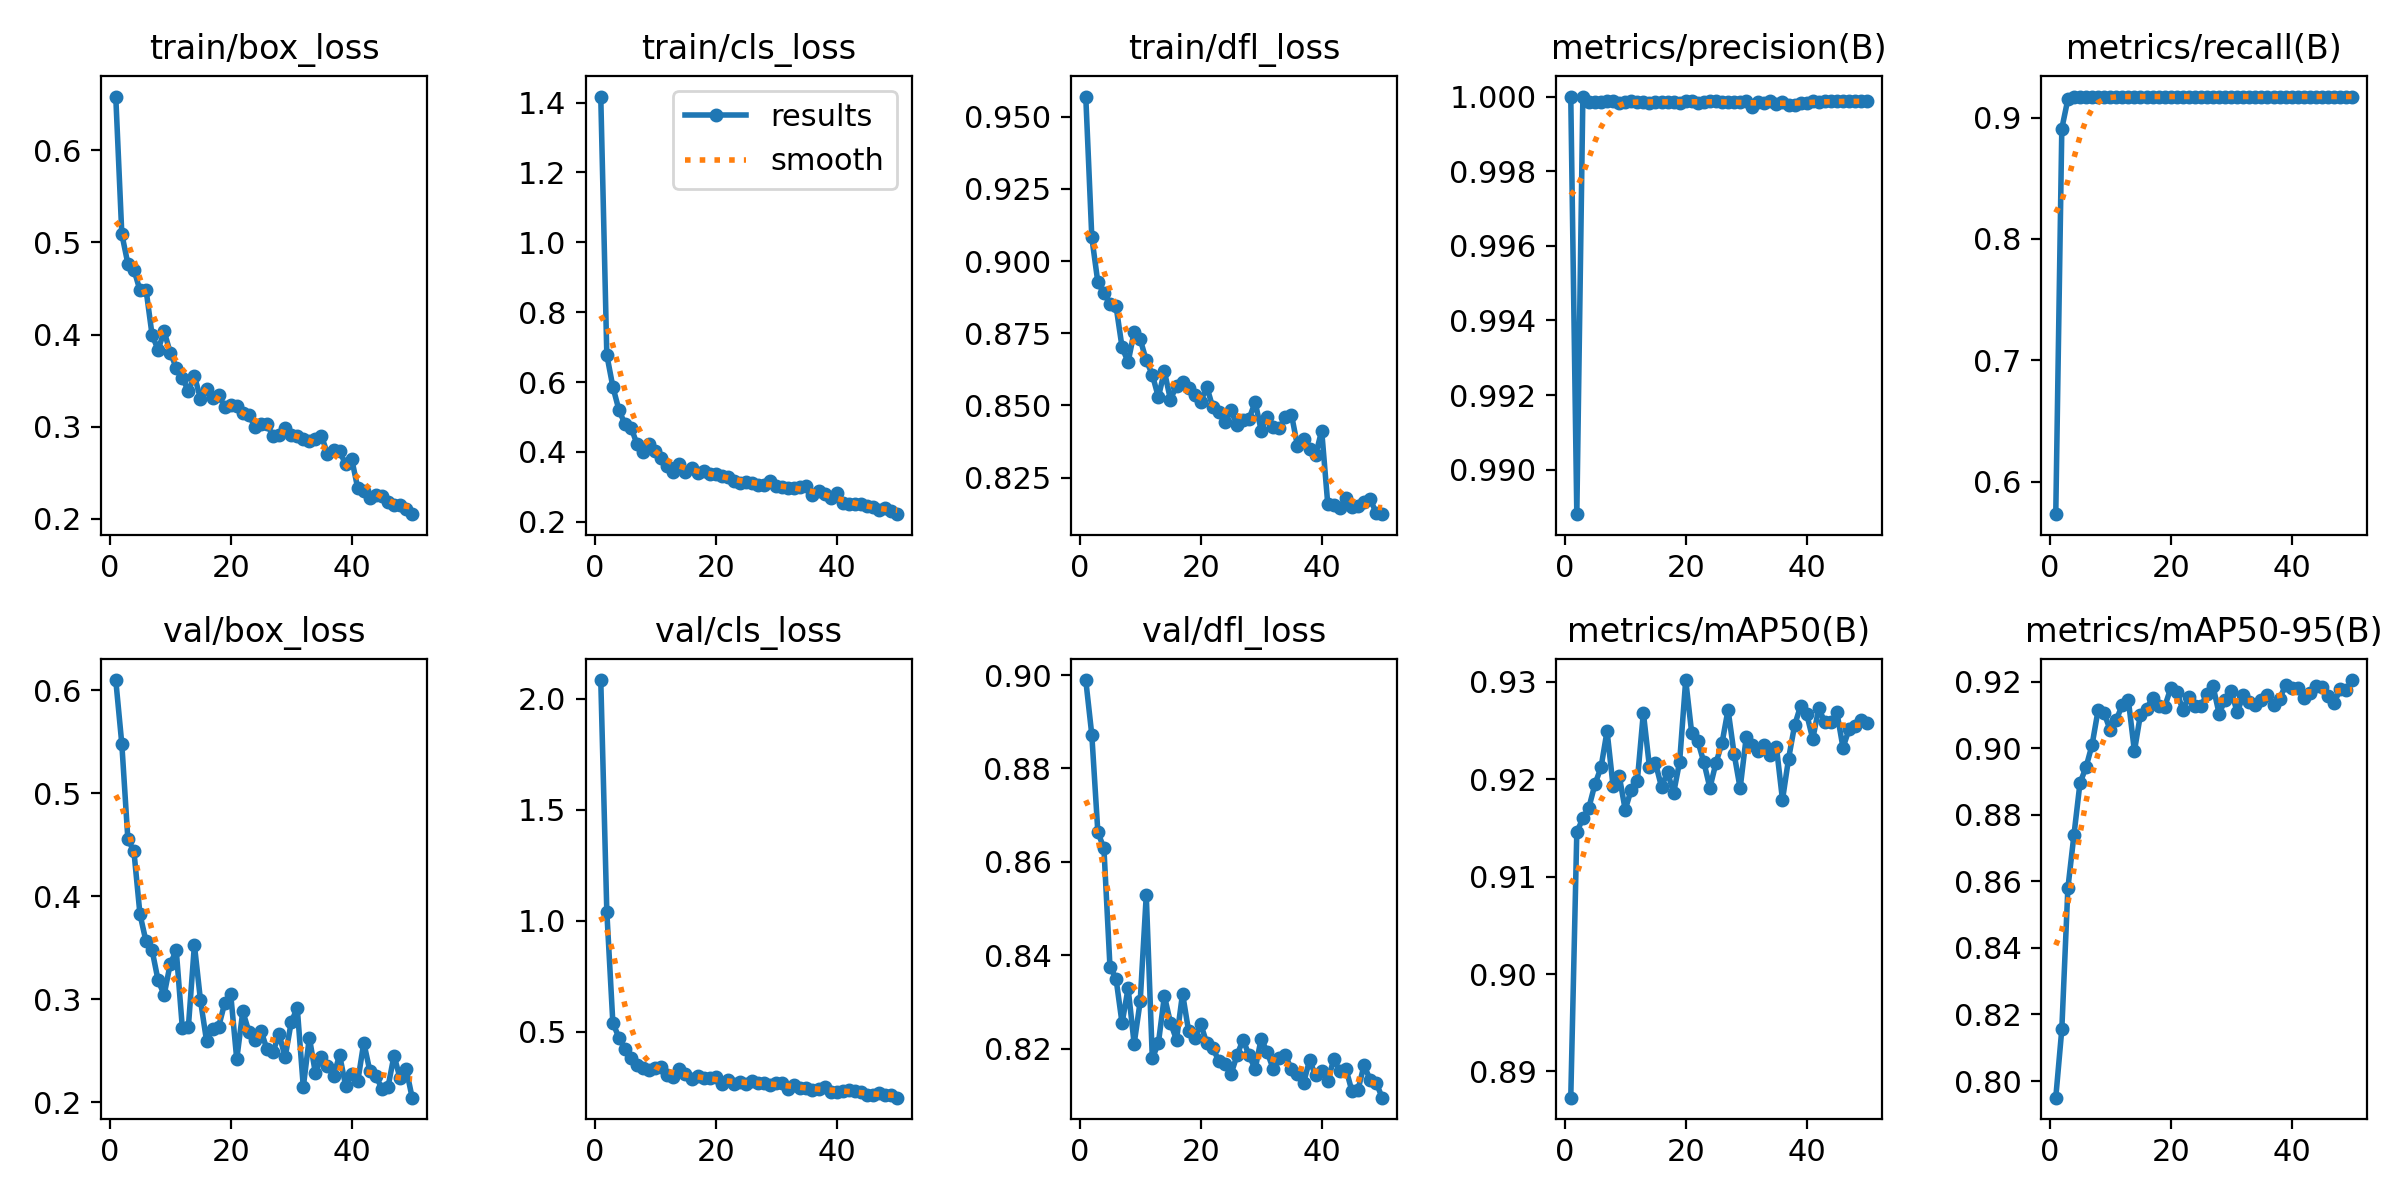

In [11]:
from IPython.display import Image
Image(filename=f'/content/runs/detect/train2/results.png' )


# TensorBoard Metrics Visualization

This script visualizes training metrics from TensorBoard logs.

## Purpose

- **Load Logs**: Reads TensorBoard logs from the specified directory to extract training metrics.
- **Extract Metrics**: Retrieves values for Box Loss, Class Loss, and DFL Loss.
- **Plot Metrics**: Creates plots to show the trends of Box Loss, Class Loss, and DFL Loss over training epochs, helping to monitor and evaluate model performance.


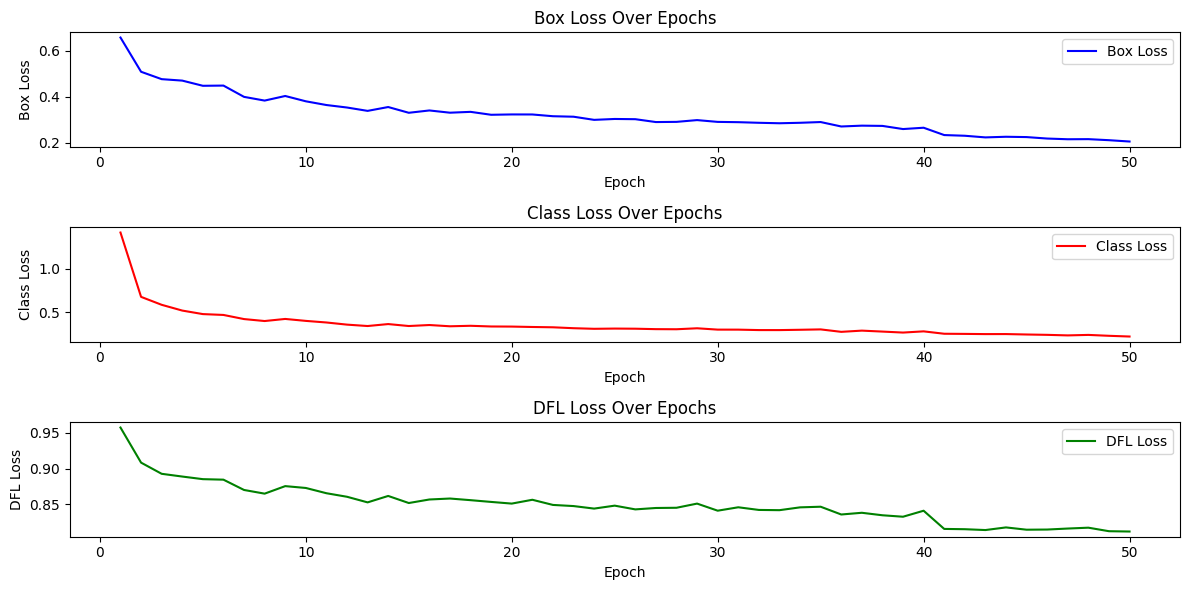

In [12]:
import os
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

log_dir = '/content/runs/detect/train2'


event_acc = event_accumulator.EventAccumulator(log_dir)
event_acc.Reload()

epochs = []
box_loss = []
cls_loss = []
dfl_loss = []

for event in event_acc.Scalars('train/box_loss'):
    epochs.append(event.step)
    box_loss.append(event.value)

for event in event_acc.Scalars('train/cls_loss'):
    cls_loss.append(event.value)

for event in event_acc.Scalars('train/dfl_loss'):
    dfl_loss.append(event.value)

#metrics
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(epochs, box_loss, label='Box Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs, cls_loss, label='Class Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Class Loss')
plt.title('Class Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epochs, dfl_loss, label='DFL Loss', color='g')
plt.xlabel('Epoch')
plt.ylabel('DFL Loss')
plt.title('DFL Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


# Model Inference on Test Images

This script performs inference using a trained YOLO model on a set of test images.

## Purpose

- **Setup Paths**: Defines paths for the model, test images, and results directory.
- **Create Results Directory**: Ensures the results directory exists.
- **Load Model**: Loads the trained YOLO model from the specified path.
- **Run Inference**: Applies the model to the test images and saves the inference results to the specified directory.

## Details

- **Model Path**: `/content/runs/detect/train2/weights/best.pt`
- **Test Images Path**: `/content/drive/MyDrive/circle_dataset/test/images`
- **Results Path**: `/content/results`


In [22]:
import os

# Paths
model_path = '/content/runs/detect/train2/weights/best.pt'
test_images_path = '/content/drive/MyDrive/circle_dataset/test/images'  # Path to your test images
results_path = '/content/results'  # Path to save results

# directory to save the results if it does not exist
os.makedirs(results_path, exist_ok=True)

# Loads the trained model
model = YOLO(model_path)

# inference on test images
results = model.predict(source=test_images_path, save=True, project=results_path, name='inference')



image 1/295 /content/drive/MyDrive/circle_dataset/test/images/image_0.png: 640x640 2 circles, 12.7ms
image 2/295 /content/drive/MyDrive/circle_dataset/test/images/image_1001.png: 640x640 4 circles, 8.0ms
image 3/295 /content/drive/MyDrive/circle_dataset/test/images/image_1004.png: 640x640 3 circles, 8.1ms
image 4/295 /content/drive/MyDrive/circle_dataset/test/images/image_1006.png: 640x640 3 circles, 8.0ms
image 5/295 /content/drive/MyDrive/circle_dataset/test/images/image_101.png: 640x640 3 circles, 8.6ms
image 6/295 /content/drive/MyDrive/circle_dataset/test/images/image_1029.png: 640x640 2 circles, 8.1ms
image 7/295 /content/drive/MyDrive/circle_dataset/test/images/image_1042.png: 640x640 4 circles, 8.1ms
image 8/295 /content/drive/MyDrive/circle_dataset/test/images/image_1048.png: 640x640 4 circles, 8.2ms
image 9/295 /content/drive/MyDrive/circle_dataset/test/images/image_105.png: 640x640 2 circles, 10.3ms
image 10/295 /content/drive/MyDrive/circle_dataset/test/images/image_1053.p

In [23]:
inference_path = '/content/results/inference'  # Path to inference results


# Function: `display_image`

## Purpose

Displays a single image using OpenCV for loading and matplotlib for visualization.

## Details

- **Input**: `image_path` - The file path to the image you want to display.
- **Process**:
  - Reads the image from the specified path using OpenCV (`cv2.imread`).
  - Converts the image from BGR to RGB color format (`cv2.cvtColor`) for correct display in matplotlib.
  - Displays the image using matplotlib (`plt.imshow`).
  - Hides the axes for a cleaner view (`plt.axis('off')`).





In [24]:
def display_image(image_path):
    """Display a single image using OpenCV and matplotlib."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

In [25]:
def display_batch_images(image_paths):
    """Display a batch of images using matplotlib."""
    plt.figure(figsize=(12, 12))
    num_images = 30
    num_cols = 10  # Number of columns for images
    num_rows = (num_images + num_cols - 1) // num_cols  # Compute number of rows

    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')  # Hide axes
        plt.title(f'Image {i + 1}')

    plt.show()

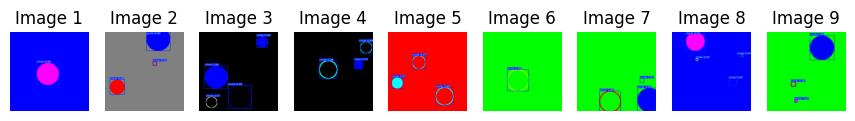

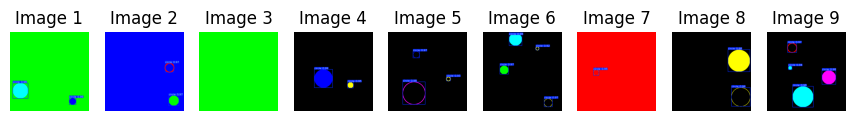

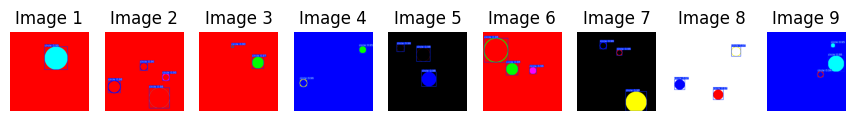

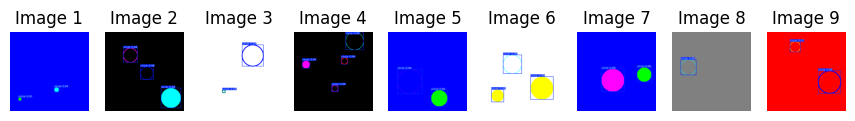

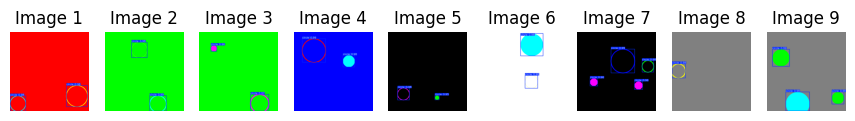

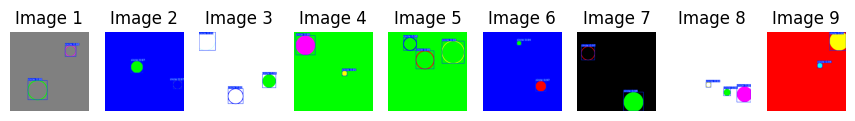

In [27]:
# Get all images from the inference directory
inference_images = [os.path.join(inference_path, filename) for filename in os.listdir(inference_path) if filename.endswith('.png')]

# Display images in batches
batch_size = 9  # Number of images per batch
for i in range(0, 50, batch_size):
    display_batch_images(inference_images[i:i + batch_size])

# Model Evaluation Results

- **Model Summary**: 168 layers, 3,005,843 parameters, 8.1 GFLOPs

## Test Results

- **Dataset**: test dataset with 189 images
- **Instances**: 496 detected objects

### Performance Metrics

- **Precision (P)**: 0.917
- **Recall (R)**: 0.926
- **mAP50 (Mean Average Precision at IoU=0.5)**: 0.919
- **mAP50-95 (Mean Average Precision at IoU=0.5 to 0.95)**: 0.919

### Inference Speed

- **Preprocess**: 1.6ms per image
- **Inference**: 5.3ms per image
- **Loss Calculation**: 0.1ms per image
- **Postprocess**: 4.7ms per image
=



In [28]:
!yolo val model='/content/runs/detect/train2/weights/best.pt' data='/content/drive/MyDrive/circle_dataset/dataset.yaml'


Ultralytics YOLOv8.2.75 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/circle_dataset/valid/labels.cache... 189 images, 0 backgrounds, 0 corrupt: 100% 189/189 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 12/12 [00:05<00:00,  2.23it/s]
                   all        189        496          1      0.917      0.926      0.919
Speed: 1.6ms preprocess, 5.3ms inference, 0.1ms loss, 4.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val
